# **FGV EESP**

- ## Dados Econômicos - Brasil
---



### **Bibliotecas**

In [1]:
# Obter os dados do SGS do Banco Central do Brasil
install.packages("rbcb")

# Gráficos de sazonalidade
install.packages("forecast")

# Testes de raiz unitária
install.packages("urca")

# Estatística descritiva
install.packages("stargazer")

# Painéis com gráficos
install.packages("gridExtra")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘zoo’, ‘xts’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘TTR’, ‘quadprog’, ‘quantmod’, ‘fracdiff’, ‘lmtest’, ‘Rcpp’, ‘timeDate’, ‘tseries’, ‘urca’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(dplyr)
library(forecast)
library(ggplot2)
library(gridExtra)
library(rbcb)
library(readxl)
library(tidyverse)
library(stargazer)
library(urca)
library(zoo)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ gridExtra::combine() masks dplyr::combine()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::lag()         masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Please cite as: 


 Hlavac, Marek (2022). stargazer: Well

### **Dados**

In [66]:
# Indicador de Expectativa de Inflação dos Consumidores
# Código FGV Dados: 1416188

# Caminho do arquivo original
file_path <- "https://github.com/matheusrmorgado/inflation-expectation/raw/main/data/fgv_ibre.xlsx"

# Download do arquivo
download.file(file_path, "fgv_ibre.xlsx")

# Ler o arquivo Excel e converter em dataframe
df_fgv <- as.data.frame(read_excel("fgv_ibre.xlsx"))

# Ajustar a coluna month_date para o tipo Date
df_fgv <- df_fgv %>% mutate(month_date = as.Date(month_date))

# Filtrar os dados de 2006-01-01 até 2023-06-01
df_fgv <- df_fgv %>% filter(month_date >= as.Date("2006-01-01") & month_date <= as.Date("2023-06-01"))

# Ajustar a coluna month para o formato de ano.mês_decimal
df_fgv$month <- year(df_fgv$month_date) + (month(df_fgv$month_date) - 1) / 12
month <- ts(df_fgv$month, start = c(2006, 1), frequency = 12)

# Conversão em formato timeseries
consumer_inflation_expectation <- ts(df_fgv$consumer_inflation_expectation, start = c(2006, 1), frequency = 12)

# Criar um data frame com as séries temporais
df_fgv <- data.frame(month = month, consumer_inflation_expectation = consumer_inflation_expectation)

In [77]:
# Índice nacional de preços ao consumidor amplo acumulado em 12 meses (%)
# SGS: 13522
df_ipca <- as.data.frame(get_series(13522, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
df_ipca <- rename(df_ipca, ipca = x)

# Taxa de juros Selic acumulada no mês anualizada base 252 (% a.a.)
# SGS: 4189
df_selic <- as.data.frame(get_series(4189, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
df_selic <- rename(df_selic, selic = x)

# Índice de Atividade Econômica do Banco Central com ajuste sazonal (índice)
# SGS: 24364
df_ibc_br <- as.data.frame(get_series(24364, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
df_ibc_br <- rename(df_ibc_br, ibc_br = x)

# Dívida Líquida do Governo Geral (% PIB)
# SGS: 4536
df_gov_debt <- as.data.frame(get_series(4536, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
df_gov_debt <- rename(df_gov_debt, gov_debt = x)

# Endividamento das famílias com o SFN em relação à renda acumulada dos últimos 12 meses (%)
# SGS: 29037
df_household_debt <- as.data.frame(get_series(29037, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
df_household_debt <- rename(df_household_debt, household_debt = x)

# RNDBF restrita - valores correntes, acumulada 12 meses - R$ (bilhões)/
# SGS: 7836
df_household_income <- as.data.frame(get_series(7836, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
df_household_income <- rename(df_household_income, household_income = x)

# PIB acumulado dos últimos 12 meses - Valores correntes - R$ (bilhões)
# SGS: 4382
df_pib <- as.data.frame(get_series(4382, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
df_pib <- rename(df_pib, pib = x)

# Taxa de câmbio - Livre - Dólar americano (compra) - Fim de período - mensal (u.m.c./US$)
# SGS: 3695
df_usd_brl <- as.data.frame(get_series(3695, start_date = "2006-01-01", end_date = "2023-06-01", as = "ts"))
df_usd_brl <- rename(df_usd_brl, usd_brl = x)

Skipping download - using cached version

Skipping download - using cached version

Skipping download - using cached version

Skipping download - using cached version

Skipping download - using cached version

Skipping download - using cached version

Skipping download - using cached version

Skipping download - using cached version

Skipping download - using cached version

Skipping download - using cached version

Skipping download - using cached version

Skipping download - using cached version

Skipping download - using cached version

Skipping download - using cached version

Skipping download - using cached version

Skipping download - using cached version



In [82]:
# Realiza a unificação de todas as tabelas do BCB e FGV IBRE
df_public_data <- cbind(df_fgv, df_ipca, df_selic, df_ibc_br, df_gov_debt, df_household_debt, df_household_income, df_pib, df_usd_brl)

# Extrair o ano e o mês da coluna "month" e criar a coluna "month_date" no formato "YYYY-MM-01"
df_public_data$month_date <- as.Date(paste(floor(df_public_data$month), floor((df_public_data$month - floor(df_public_data$month)) * 12) + 1, "01", sep = "-"))

# # Reorganiza as colunas, colocando "month_date" e "month" nas primeiras posições
df_public_data <- df_public_data %>% select(month_date, month, everything())

In [95]:
str(df_public_data)

'data.frame':	210 obs. of  11 variables:
 $ month_date                    : Date, format: "2006-01-01" "2006-01-01" ...
 $ month                         : Time-Series  from 2006 to 2023: 2006 2006 2006 2006 2006 ...
 $ consumer_inflation_expectation: Time-Series  from 2006 to 2023: 6.9 7 6.9 6.5 6.7 6.3 6.9 6.4 6.3 5.8 ...
 $ ipca                          : Time-Series  from 2006 to 2023: 5.7 5.51 5.32 4.63 4.23 4.03 3.97 3.84 3.7 3.26 ...
 $ selic                         : Time-Series  from 2006 to 2023: 17.6 17.3 16.7 16.2 15.7 ...
 $ ibc_br                        : Time-Series  from 2006 to 2023: 114 114 113 114 116 ...
 $ gov_debt                      : Time-Series  from 2006 to 2023: 46.7 46.4 46.4 45.6 46.2 ...
 $ household_debt                : Time-Series  from 2006 to 2023: 19.9 20.1 20.4 20.8 21.1 ...
 $ household_income              : Time-Series  from 2006 to 2023: 167991 169200 166456 165894 165256 ...
 $ pib                           : Time-Series  from 2006 to 2023: 2190

In [84]:
head(df_public_data, 5)

,month_date,month,consumer_inflation_expectation,ipca,selic,ibc_br,gov_debt,household_debt,household_income,pib,usd_brl
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2006-01-01,2006.000,6.9,5.70,17.65,113.55,46.68,19.89,167991,2190643,2.2152
2,2006-01-01,2006.083,7.0,5.51,17.28,113.72,46.38,20.11,169200,2207671,2.1347
3,2006-03-01,2006.167,6.9,5.32,16.74,113.45,46.38,20.45,166456,2225145,2.1716
4,2006-04-01,2006.250,6.5,4.63,16.19,114.32,45.59,20.78,165894,2235813,2.0884
5,2006-04-01,2006.333,6.7,4.23,15.70,115.57,46.21,21.07,165256,2256419,2.2997


### **Estatística Descritiva**

In [85]:
stargazer(df_public_data, digits = 2, type = "text")


Statistic                       N      Mean       St. Dev.       Min           Max     
---------------------------------------------------------------------------------------
month                          210   2,014.71       5.06       2,006.00     2,023.42   
consumer_inflation_expectation 210     6.95         1.66         4.30         11.40    
ipca                           210     5.70         2.24         1.88         12.13    
selic                          210    10.01         3.57         1.90         17.65    
ibc_br                         210    136.15        8.60        113.45       148.78    
gov_debt                       210    45.31        10.19        30.71         66.39    
household_debt                 210    36.35         7.57        19.89         50.09    
household_income               210  587,507.00   272,849.00    165,256      1,038,860  
pib                            210 5,536,006.00 2,163,662.00 2,190,643.00 10,323,848.00
usd_brl                        

Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


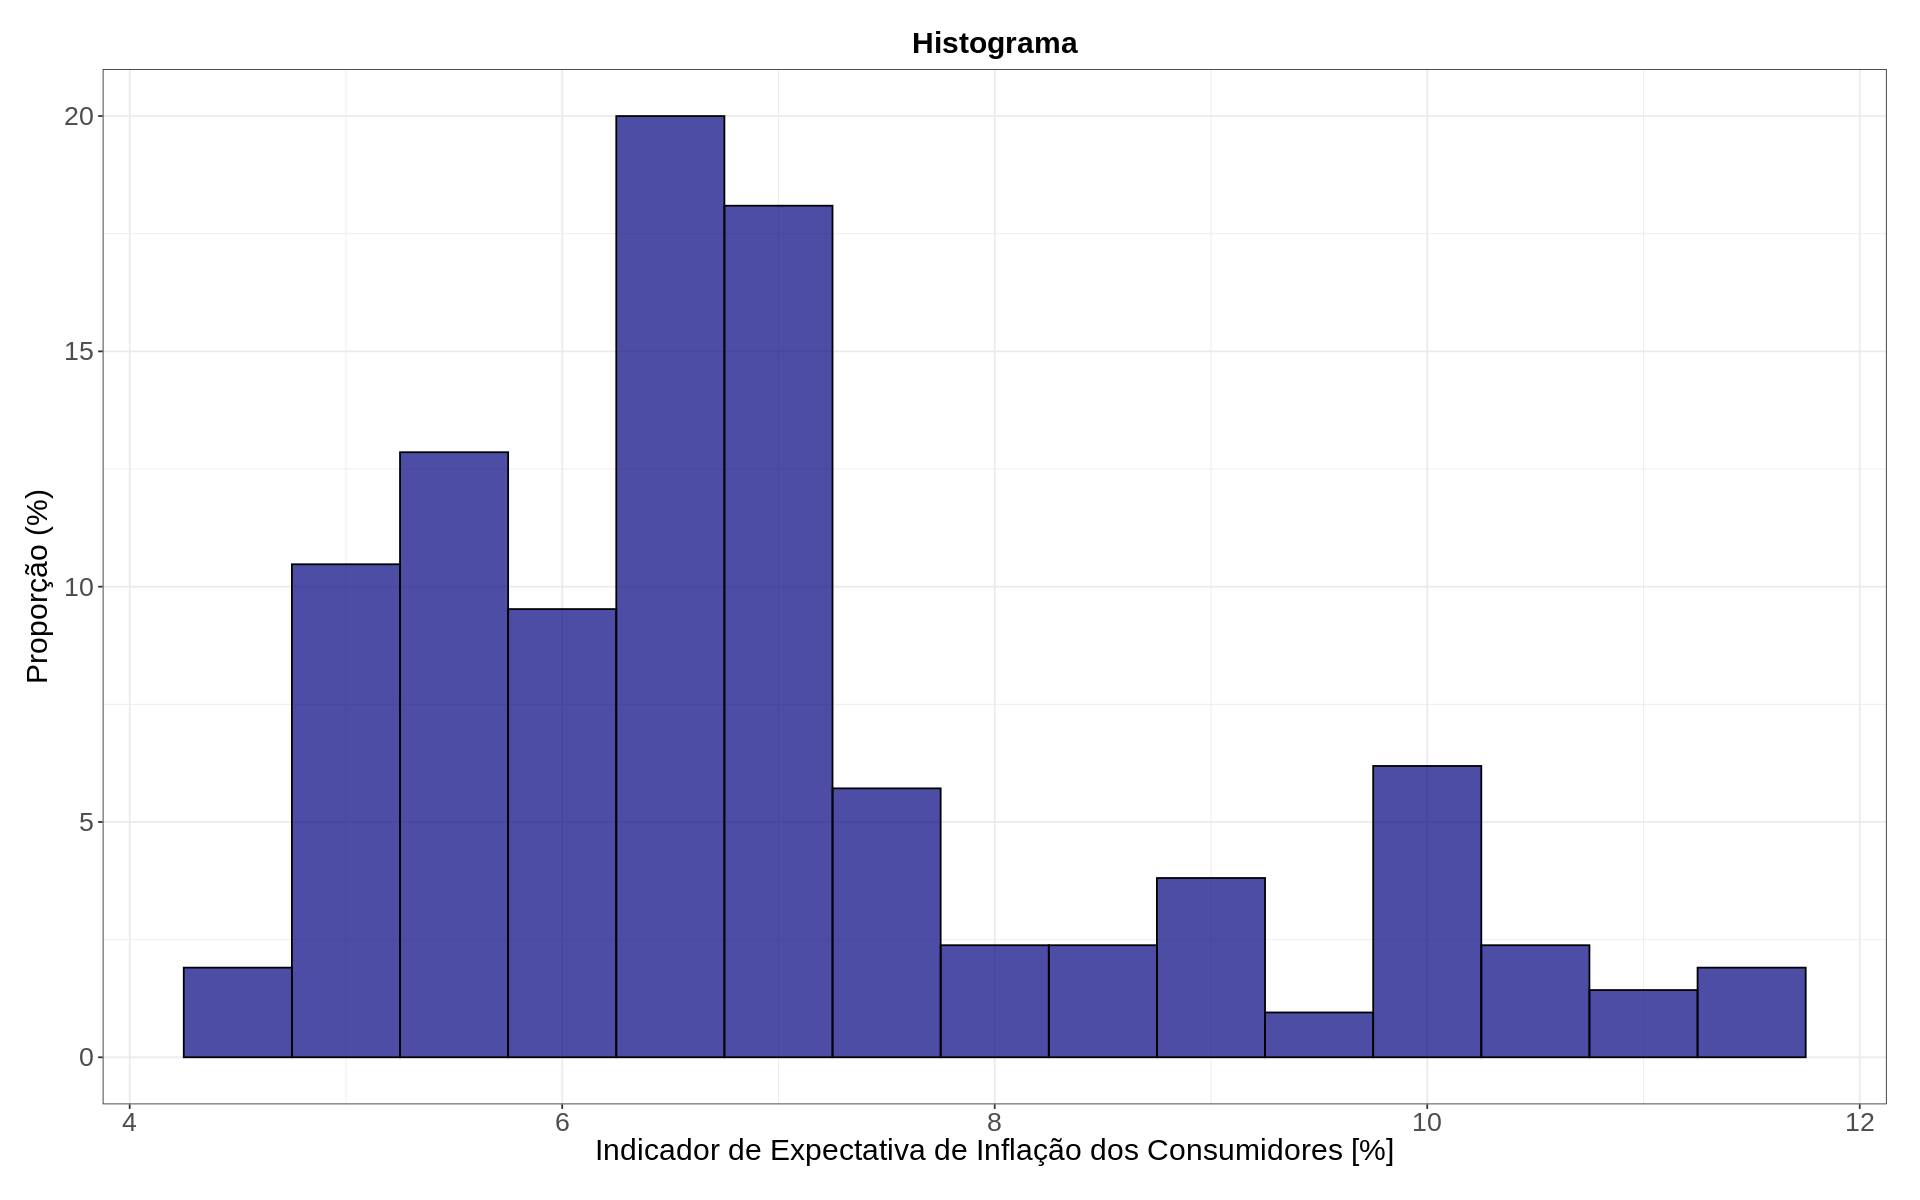

In [86]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 16, repr.plot.height = 10)

# Plotar o histograma dos valores da coluna "consumer_inflation_expectation"
ggplot(df_public_data, aes(x = consumer_inflation_expectation, y = 100 * after_stat(count) / sum(after_stat(count)))) +
  geom_histogram(binwidth = 0.5, color = "black", fill = "navy", alpha = 0.7) +
  labs(x = "Indicador de Expectativa de Inflação dos Consumidores [%]", y = "Proporção (%)", title = "Histograma") +
  theme_bw() +
  theme(
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
    axis.text = element_text(size = 16),
    axis.title.y = element_text(size = 18, vjust = 2),  # Ajuste o vjust para controlar o espaço entre o nome do eixo e os números
    axis.title.x = element_text(size = 18),  # Ajuste o tamanho do nome do eixo x
    plot.caption = element_text(size = 14),
    plot.margin = margin(20, 20, 20, 20)
  )


### **Visualização de Dados**

Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


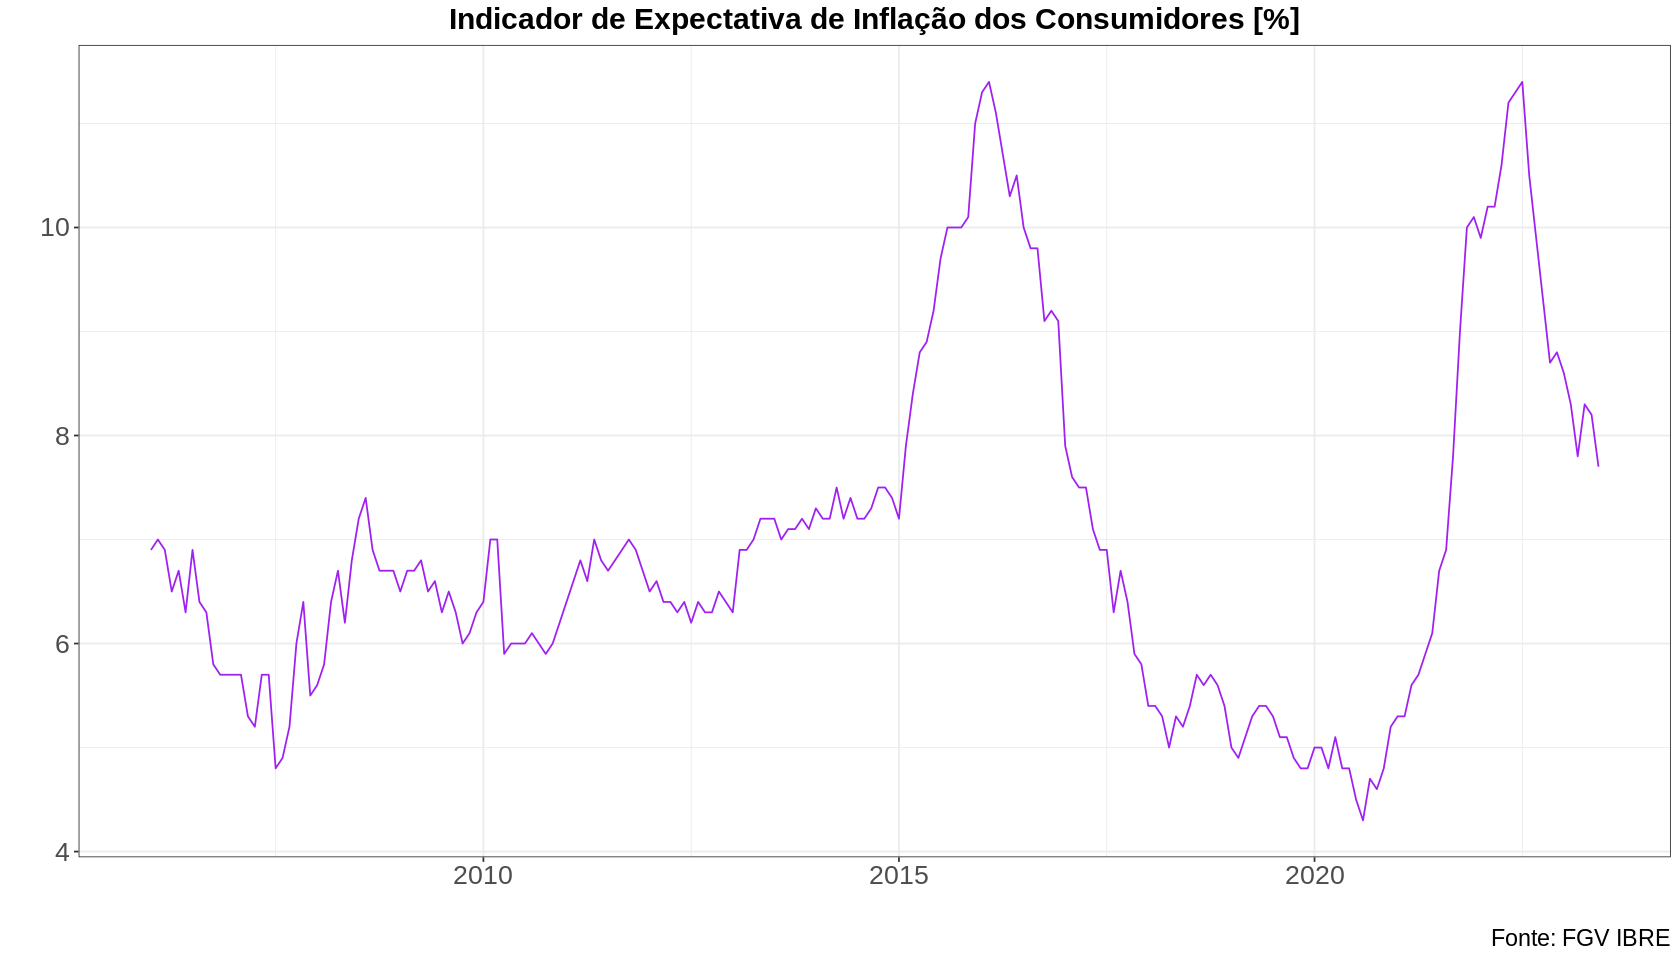

In [87]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 14, repr.plot.height = 8)

# Criar o objeto de plotagem usando ggplot
ggplot(df_public_data, aes(x = month, y = consumer_inflation_expectation)) +
  geom_line(color = "purple") +
  labs(x = "", y = "") +
  ggtitle("Indicador de Expectativa de Inflação dos Consumidores [%]") +
  theme_bw() +
  theme(plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.caption = element_text(size = 14)) +
  labs(caption = "Fonte: FGV IBRE")

Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of typ

TableGrob (4 x 2) "arrange": 8 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]
5 5 (3-3,1-1) arrange gtable[layout]
6 6 (3-3,2-2) arrange gtable[layout]
7 7 (4-4,1-1) arrange gtable[layout]
8 8 (4-4,2-2) arrange gtable[layout]


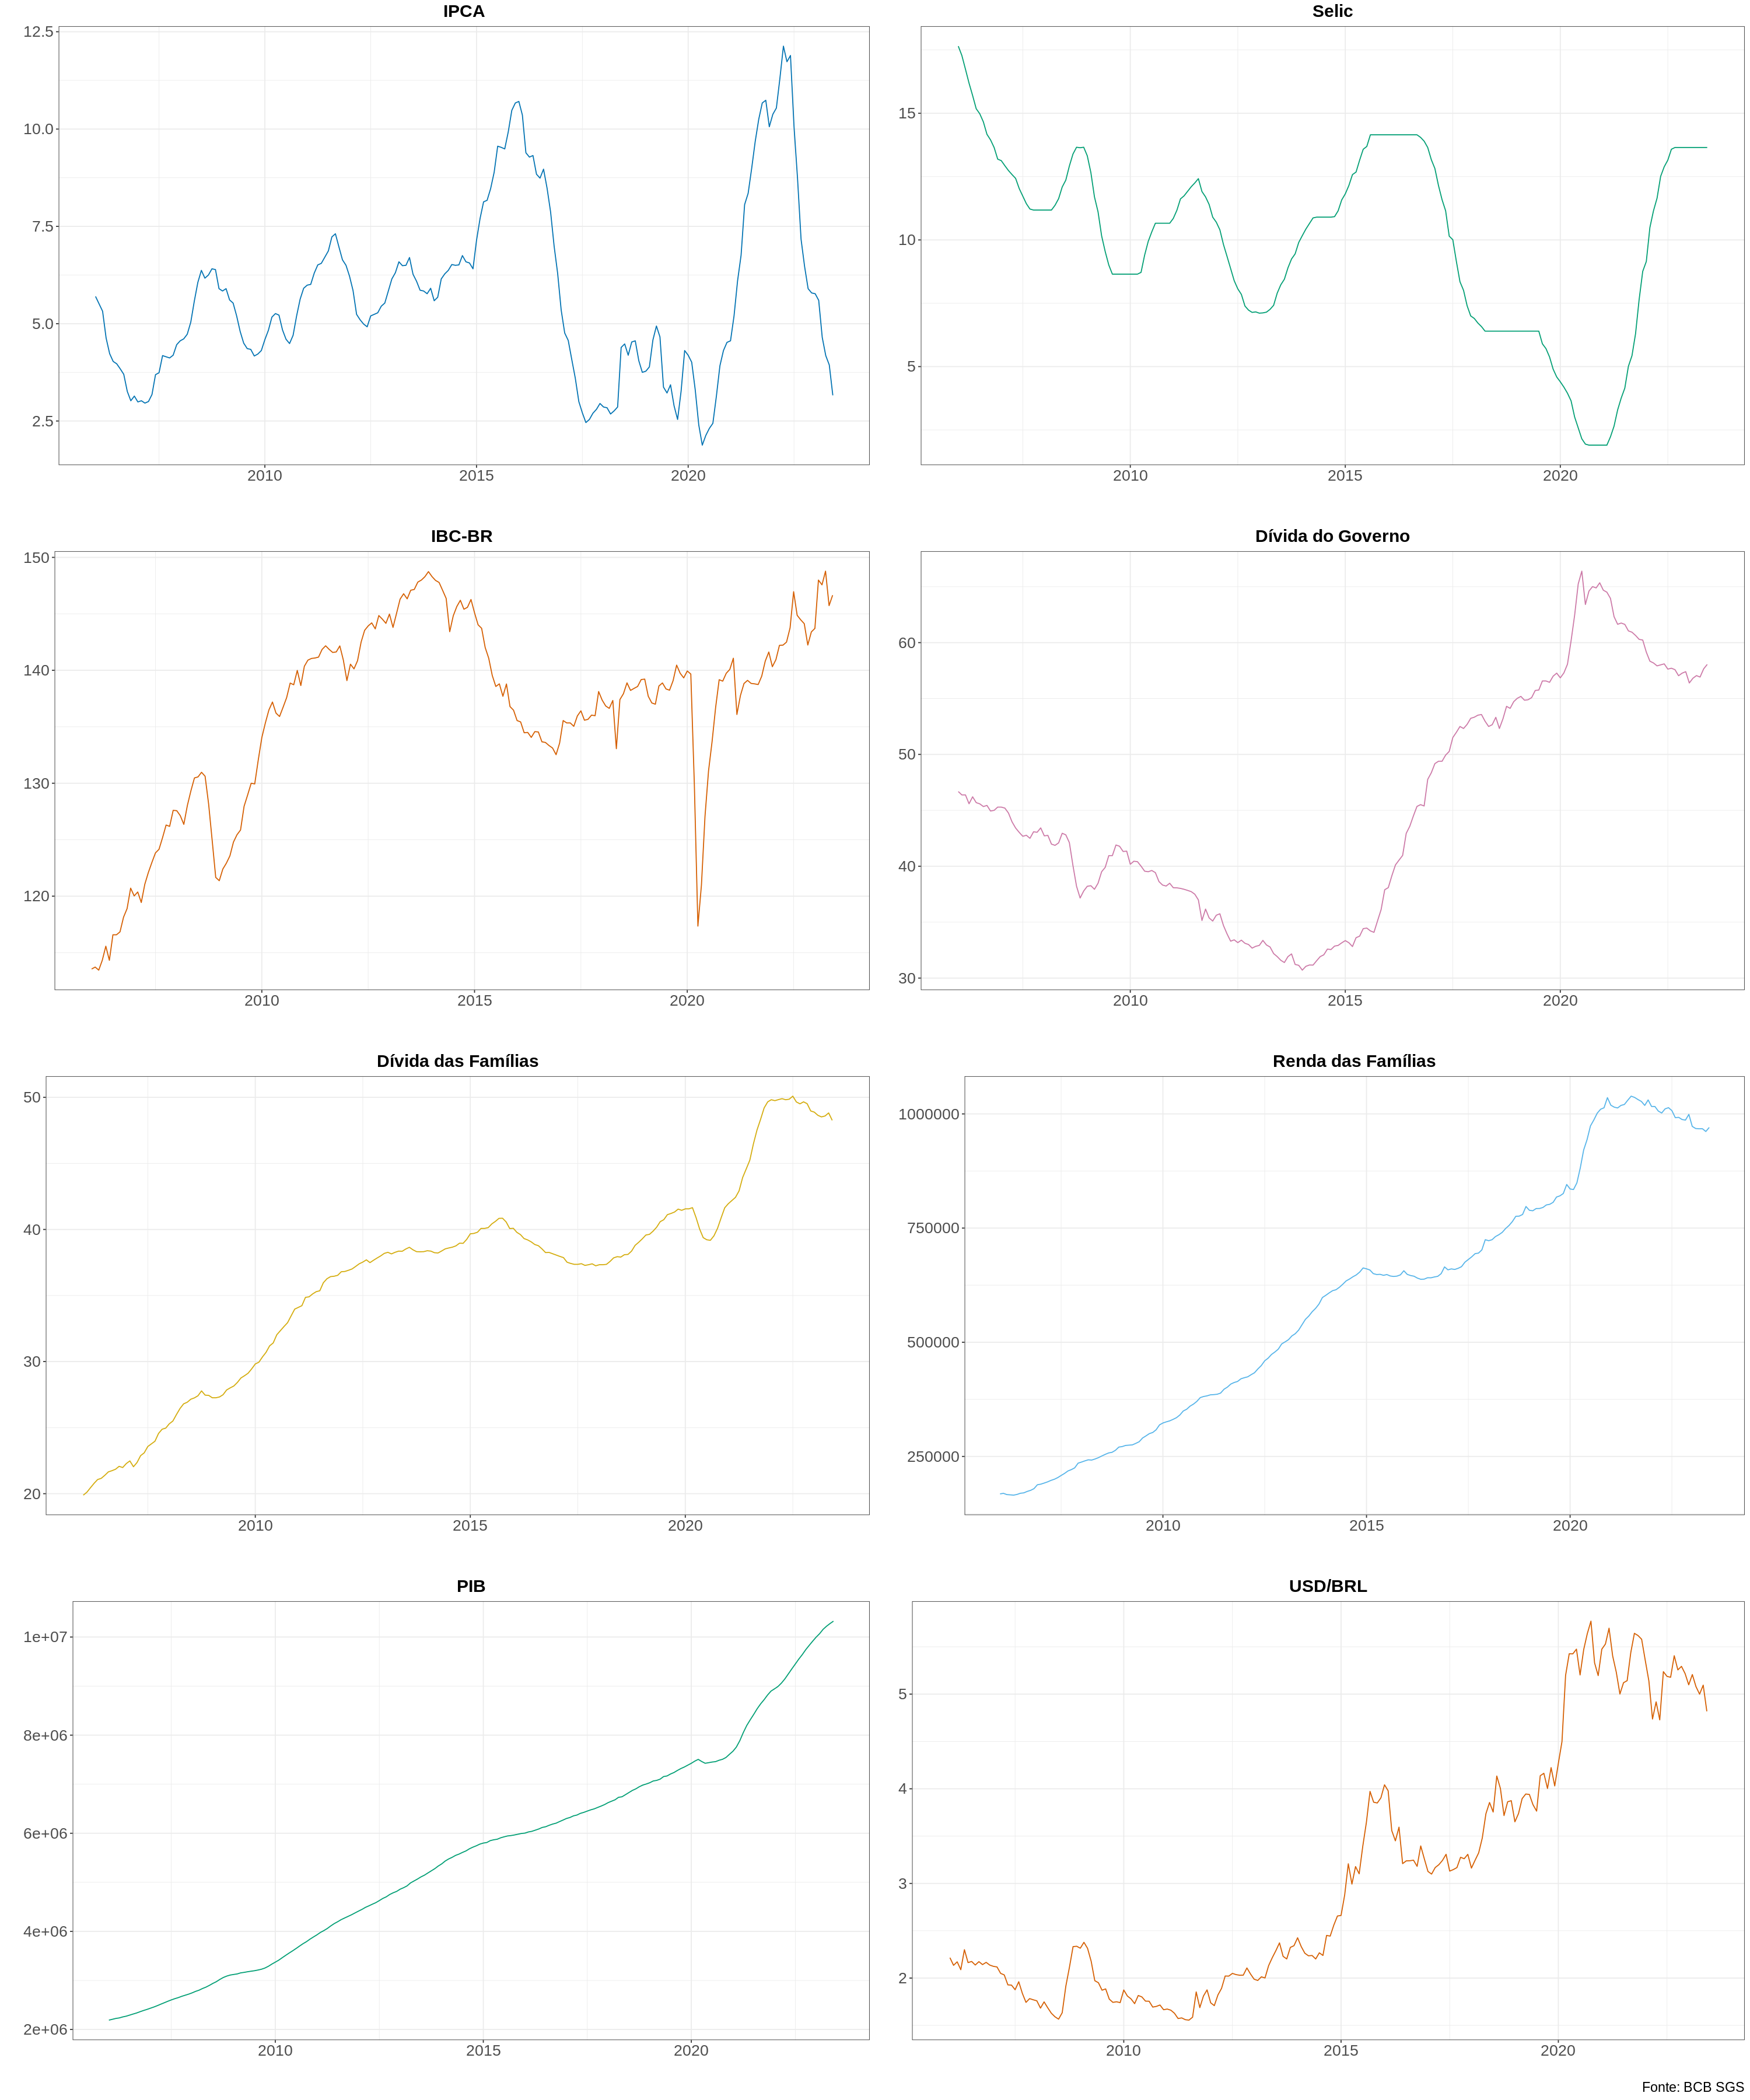

In [90]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 25, repr.plot.height = 30)  # Ajuste a altura para acomodar os 8 gráficos

# Lista de nomes das métricas
metricas <- c("ipca", "selic", "ibc_br", "gov_debt", "household_debt", "household_income", "pib", "usd_brl")

# Lista de títulos das métricas
titulos <- c("IPCA", "Selic", "IBC-BR", "Dívida do Governo", "Dívida das Famílias", "Renda das Famílias", "PIB", "USD/BRL")

# Lista de cores personalizadas
cores <- c("#0072B2", "#009E73", "#D55E00", "#CC79A7", "#D4AC0D", "#56B4E9", "#009E73", "#D55E00")

# Criar uma lista para armazenar os gráficos
graficos <- list()

# Criar os gráficos para cada métrica
for (i in 1:length(metricas)) {
  nome_metrica <- tolower(metricas[i])
  caption <- if (i == length(metricas)) "Fonte: BCB SGS" else ""  # Adicione a fonte apenas para o último gráfico
  grafico <- ggplot(df_public_data) +
    geom_line(aes(x = month, y = .data[[metricas[i]]]), color = cores[i]) +
    labs(x = "", y = "", title = titulos[i], caption = caption) +
    theme_bw() +
    theme(legend.position = "none",
          plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
          axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          plot.caption = element_text(size = 14))
  graficos[[i]] <- grafico
}

# Combinar os gráficos em um único painel
painel <- do.call(grid.arrange, c(graficos, ncol = 2))

# Apresentar o painel
print(painel)

### **Análise de Estacionariedade**

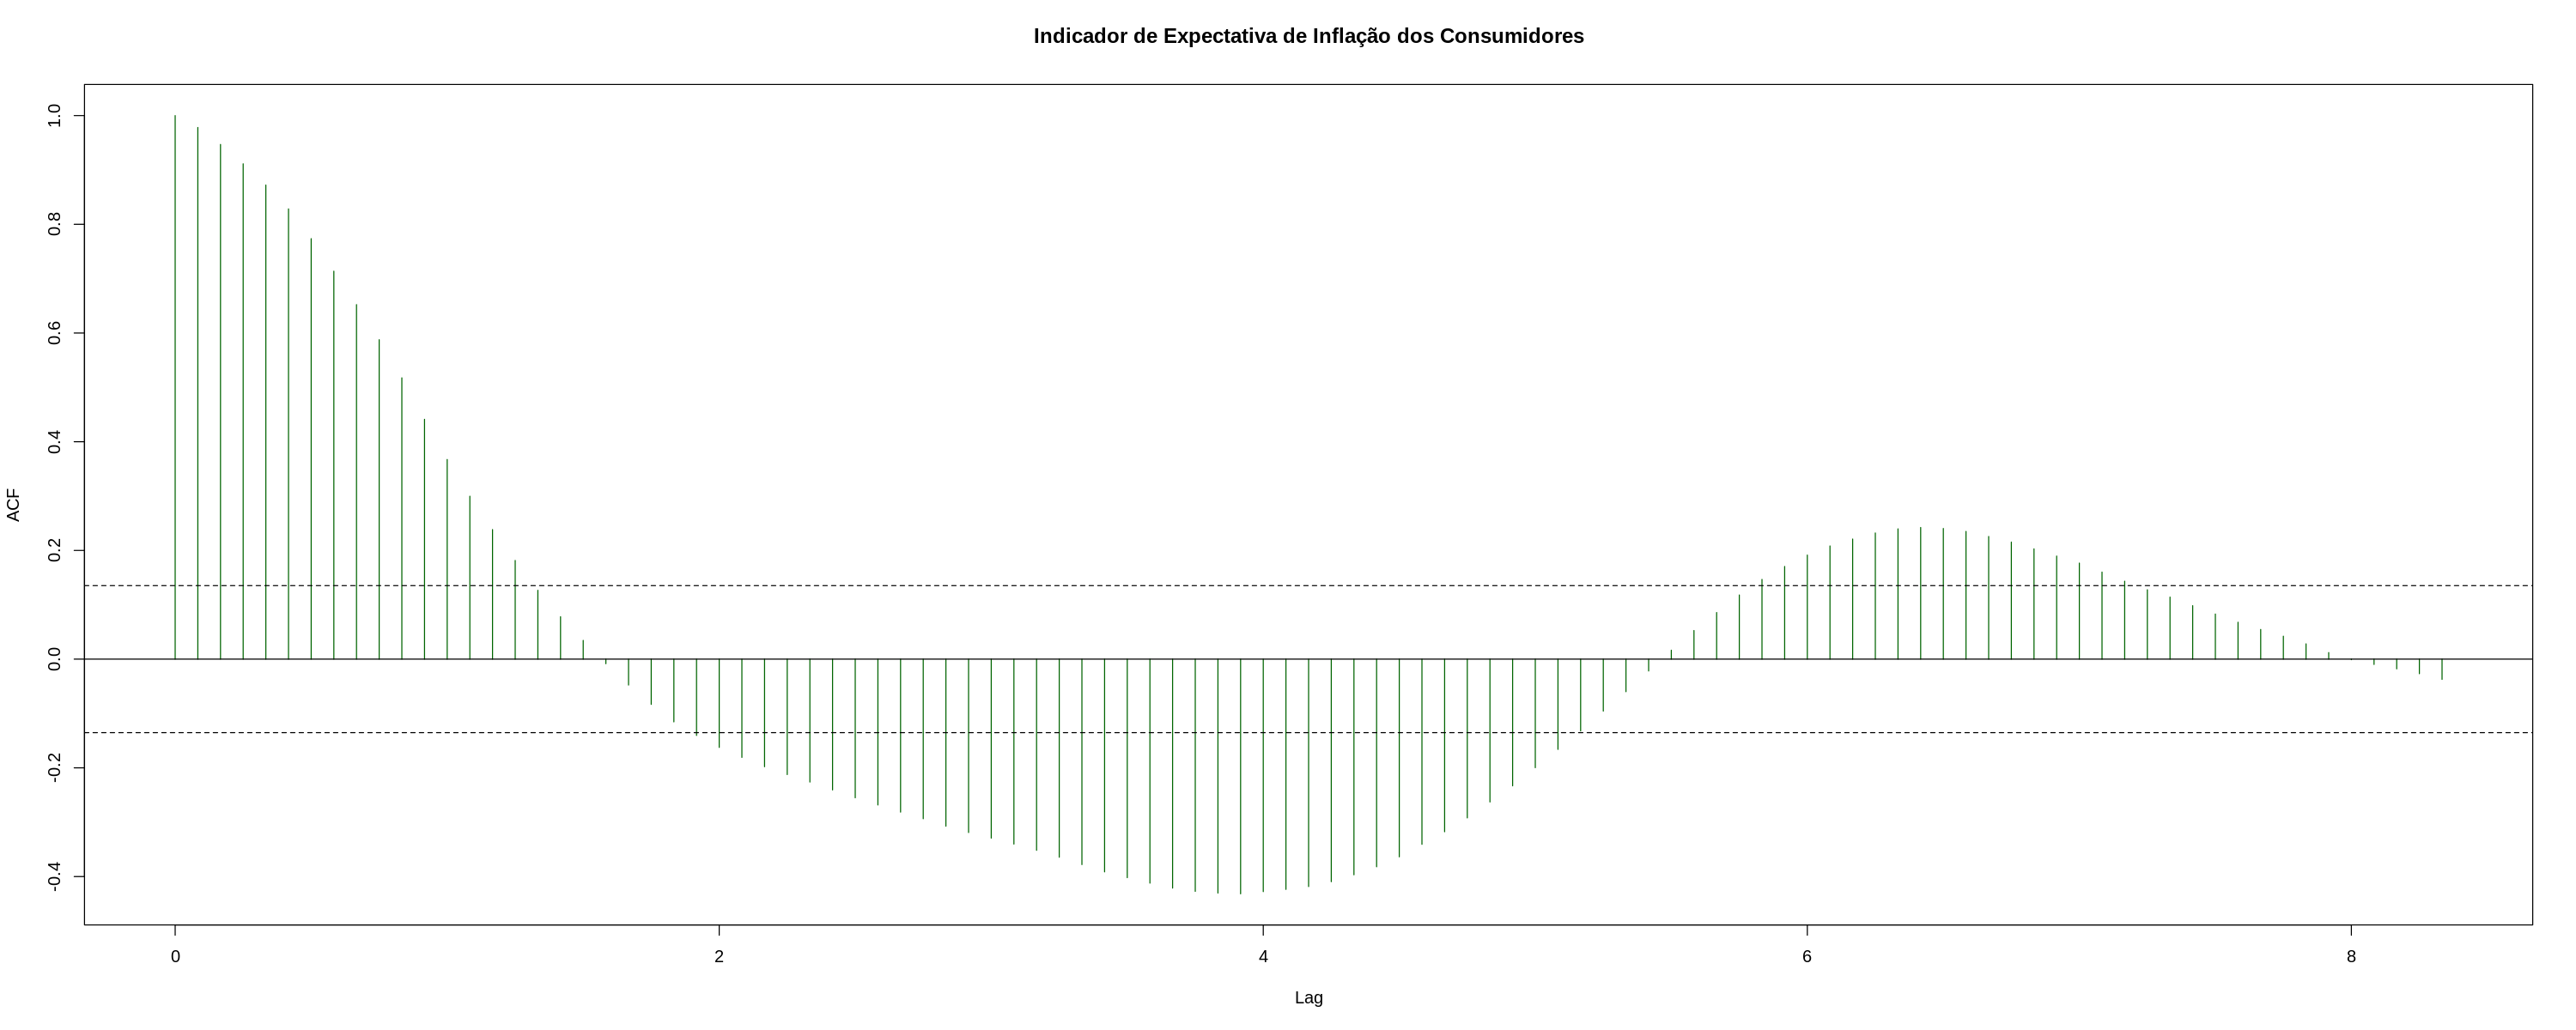

In [91]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 25, repr.plot.height = 10)  # Ajuste a altura para acomodar os 8 gráficos

# Função de Autocorrelação
acf(df_public_data$consumer_inflation_expectation,
    main = "Indicador de Expectativa de Inflação dos Consumidores",
    col = "darkgreen",
    ci.col = "black",
    lag.max = 100)

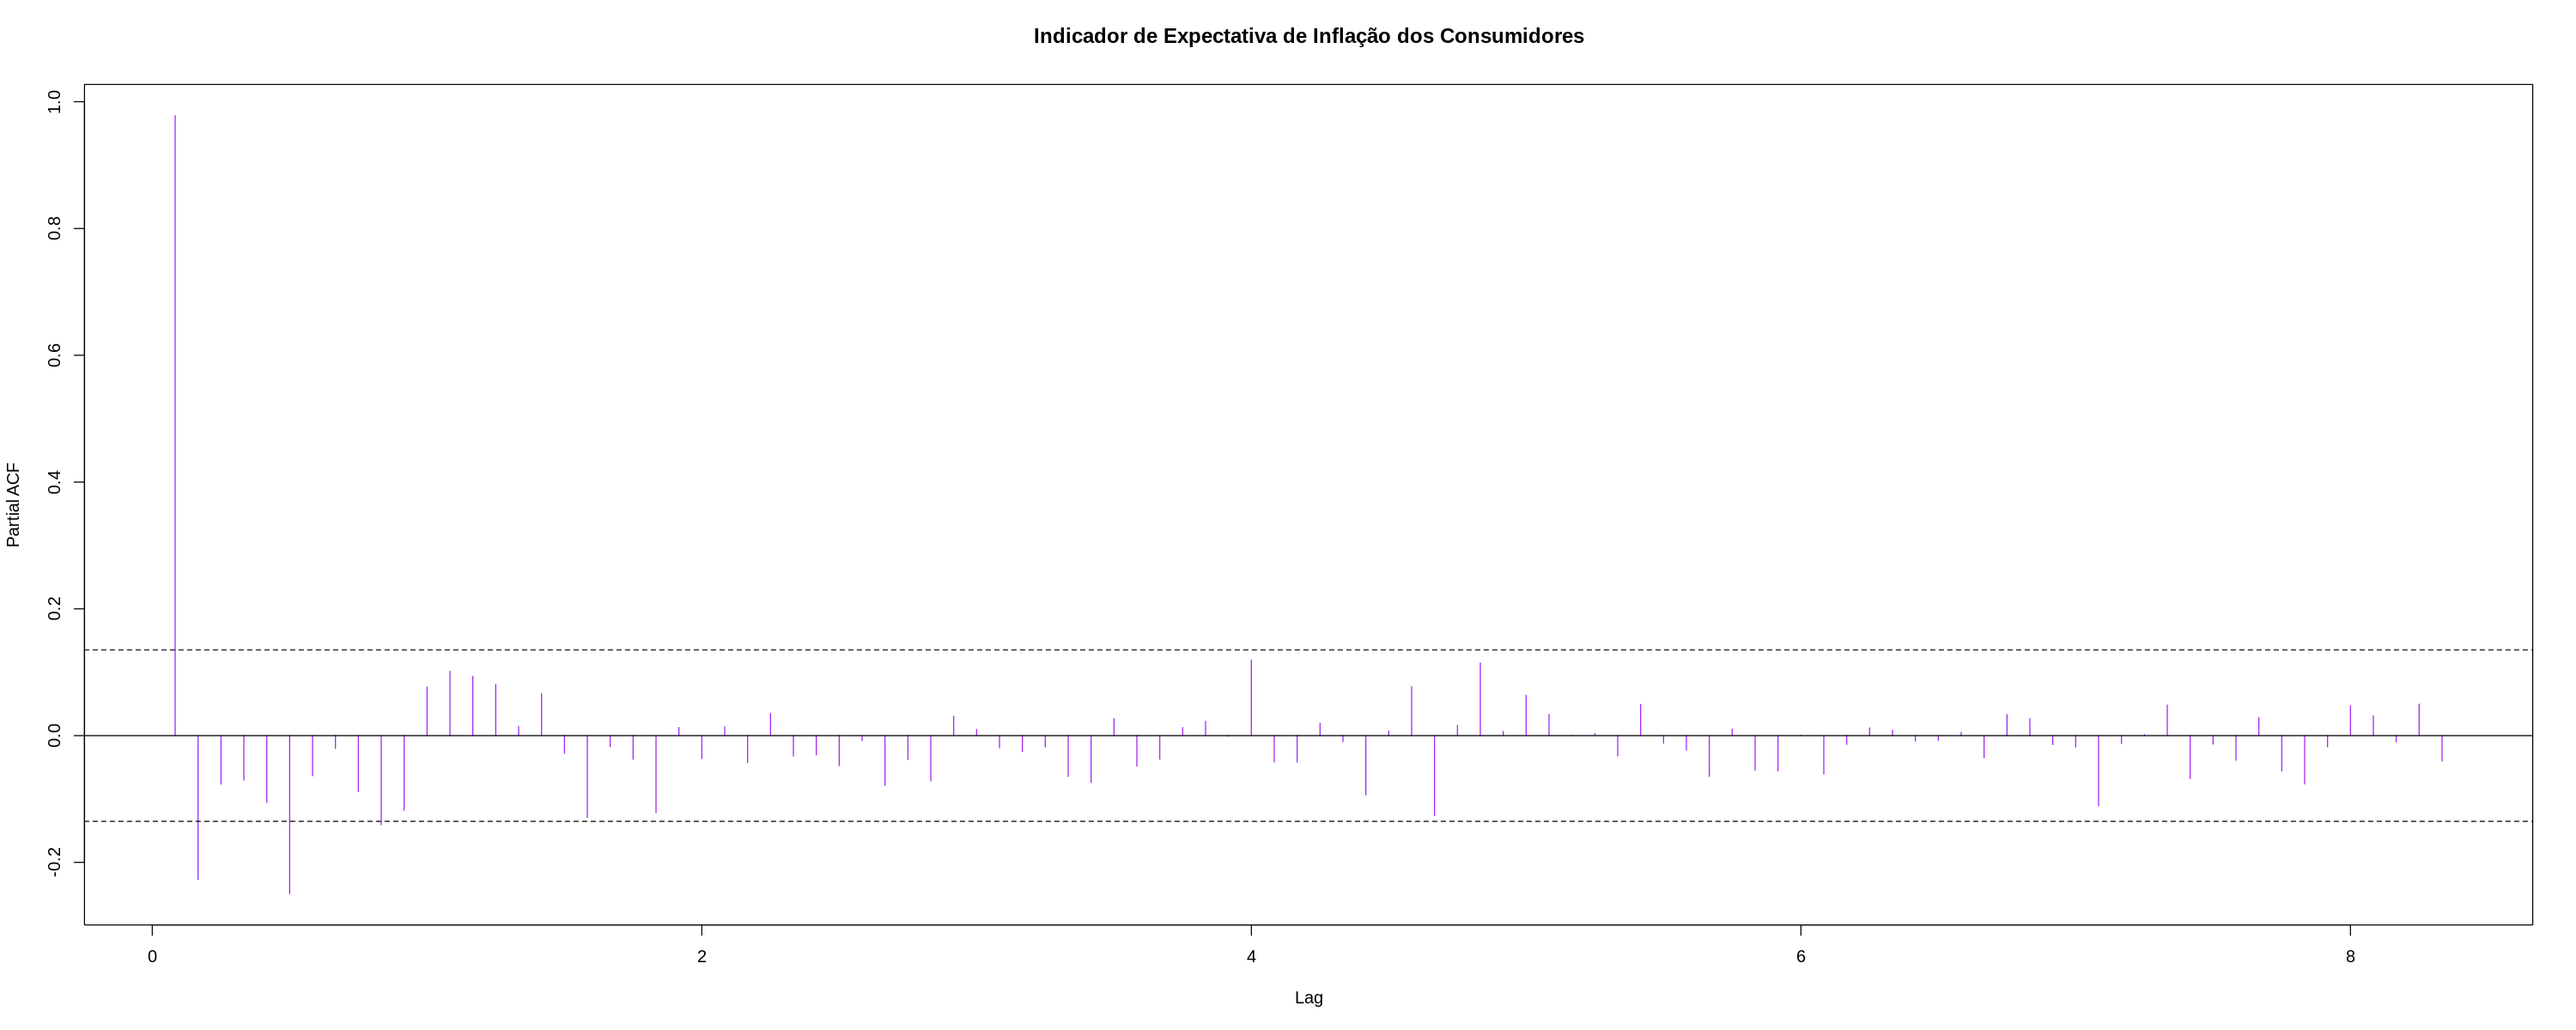

In [92]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 25, repr.plot.height = 10)  # Ajuste a altura para acomodar os 8 gráficos

# Função de Autocorrelação Parcial
pacf(df_public_data$consumer_inflation_expectation,
    main = "Indicador de Expectativa de Inflação dos Consumidores",
    col = "purple",
    ci.col = "black",
    lag.max = 100)

In [93]:
### Teste de Raiz Unitária (ADF)
summary( ur.df( df_public_data$consumer_inflation_expectation, lags=12, type='trend') )


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.09677 -0.18560 -0.00357  0.16660  0.94785 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)   
(Intercept)   0.3515298  0.1292630   2.719  0.00717 **
z.lag.1      -0.0534263  0.0184523  -2.895  0.00425 **
tt            0.0002051  0.0004114   0.499  0.61869   
z.diff.lag1   0.1955855  0.0717856   2.725  0.00707 **
z.diff.lag2   0.0156361  0.0723755   0.216  0.82920   
z.diff.lag3   0.1000963  0.0732853   1.366  0.17367   
z.diff.lag4  -0.0227473  0.0732961  -0.310  0.75665   
z.diff.lag5   0.2425796  0.0732023   3.314  0.00111 **
z.diff.lag6   0.0650533  0.0745469   0.873  0.38400   
z.diff.lag7   0.0350018  0.0735912   0.476  0.63491   
z.diff.lag8   0.0362034  0.0732818   0.494 

**Resultado**

- Como, em módulo, os valores de test-statistic são menores que tau3, phi2 e phi3, não se rejeita nenhuma das hipóteses nulas para um nível de significância de 5%, ou seja, a série temporal possui raiz unitária, o que significa que é não-estacionária.

In [94]:
### Teste de Raiz Unitária (KPSS)
summary( ur.kpss( df_public_data$consumer_inflation_expectation, type = "tau",     # média diferente de zero
                              lags = "short"    # poucos lags
                              ) )


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: tau with 4 lags. 

Value of test-statistic is: 0.2148 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.119 0.146  0.176 0.216


**Resultado**

- Como, em módulo, o valor de test-statistic é maior que o valor crítico, rejeita-se a hipótese nula para um nível de significância de 5%, ou seja, a série possui raiz unitária, o que significa que é não-estacionária.

### **Modelo VAR**